# Existing method -Rainfall prediction framework based Fuzzy Inference System optimized with Particle Swarm Optimization 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn import linear_model
from random import random
from random import uniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [ ]:
data = pd.read_csv("/content/sample_data/rainfall_in_india_1901-2015.csv",sep=",")
data = data.fillna(data.mean())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SUBDIVISION  4116 non-null   object 
 1   YEAR         4116 non-null   int64  
 2   JAN          4116 non-null   float64
 3   FEB          4116 non-null   float64
 4   MAR          4116 non-null   float64
 5   APR          4116 non-null   float64
 6   MAY          4116 non-null   float64
 7   JUN          4116 non-null   float64
 8   JUL          4116 non-null   float64
 9   AUG          4116 non-null   float64
 10  SEP          4116 non-null   float64
 11  OCT          4116 non-null   float64
 12  NOV          4116 non-null   float64
 13  DEC          4116 non-null   float64
 14  ANNUAL       4116 non-null   float64
 15  Jan-Feb      4116 non-null   float64
 16  Mar-May      4116 non-null   float64
 17  Jun-Sep      4116 non-null   float64
 18  Oct-Dec      4116 non-null   float64
dtypes: flo

In [ ]:
data.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
0,ANDAMAN & NICOBAR ISLANDS,1901,49.2,87.1,29.2,2.3,528.8,517.5,365.1,481.1,332.6,388.5,558.2,33.6,3373.2,136.3,560.3,1696.3,980.3
1,ANDAMAN & NICOBAR ISLANDS,1902,0.0,159.8,12.2,0.0,446.1,537.1,228.9,753.7,666.2,197.2,359.0,160.5,3520.7,159.8,458.3,2185.9,716.7
2,ANDAMAN & NICOBAR ISLANDS,1903,12.7,144.0,0.0,1.0,235.1,479.9,728.4,326.7,339.0,181.2,284.4,225.0,2957.4,156.7,236.1,1874.0,690.6
3,ANDAMAN & NICOBAR ISLANDS,1904,9.4,14.7,0.0,202.4,304.5,495.1,502.0,160.1,820.4,222.2,308.7,40.1,3079.6,24.1,506.9,1977.6,571.0
4,ANDAMAN & NICOBAR ISLANDS,1905,1.3,0.0,3.3,26.9,279.5,628.7,368.7,330.5,297.0,260.7,25.4,344.7,2566.7,1.3,309.7,1624.9,630.8


In [ ]:
data.describe()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
count,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000
mean,1958.218659,18.957320,21.805325,27.359197,43.127432,85.745417,230.234444,347.214334,290.263497,197.361922,95.507009,39.866163,18.870580,1411.008900,40.747786,155.901753,1064.724769,154.100487
std,33.140898,33.569044,35.896396,46.925176,67.798192,123.189974,234.568120,269.310313,188.678707,135.309591,99.434452,68.593545,42.318098,900.986632,59.265023,201.096692,706.881054,166.678751
min,1901.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,62.300000,0.000000,0.000000,57.400000,0.000000
25%,1930.000000,0.600000,0.600000,1.000000,3.000000,8.600000,70.475000,175.900000,156.150000,100.600000,14.600000,0.700000,0.100000,806.450000,4.100000,24.200000,574.375000,34.200000
50%,1958.000000,6.000000,6.700000,7.900000,15.700000,36.700000,138.900000,284.900000,259.500000,174.100000,65.750000,9.700000,3.100000,1125.450000,19.300000,75.200000,882.250000,98.800000
75%,1987.000000,22.125000,26.800000,31.225000,49.825000,96.825000,304.950000,418.225000,377.725000,265.725000,148.300000,45.825000,17.700000,1635.100000,50.300000,196.900000,1287.550000,212.600000
max,2015.000000,583.700000,403.500000,605.600000,595.100000,1168.600000,1609.900000,2362.800000,1664.600000,1222.000000,948.300000,648.900000,617.500000,6331.100000,699.500000,1745.800000,4536.900000,1252.500000


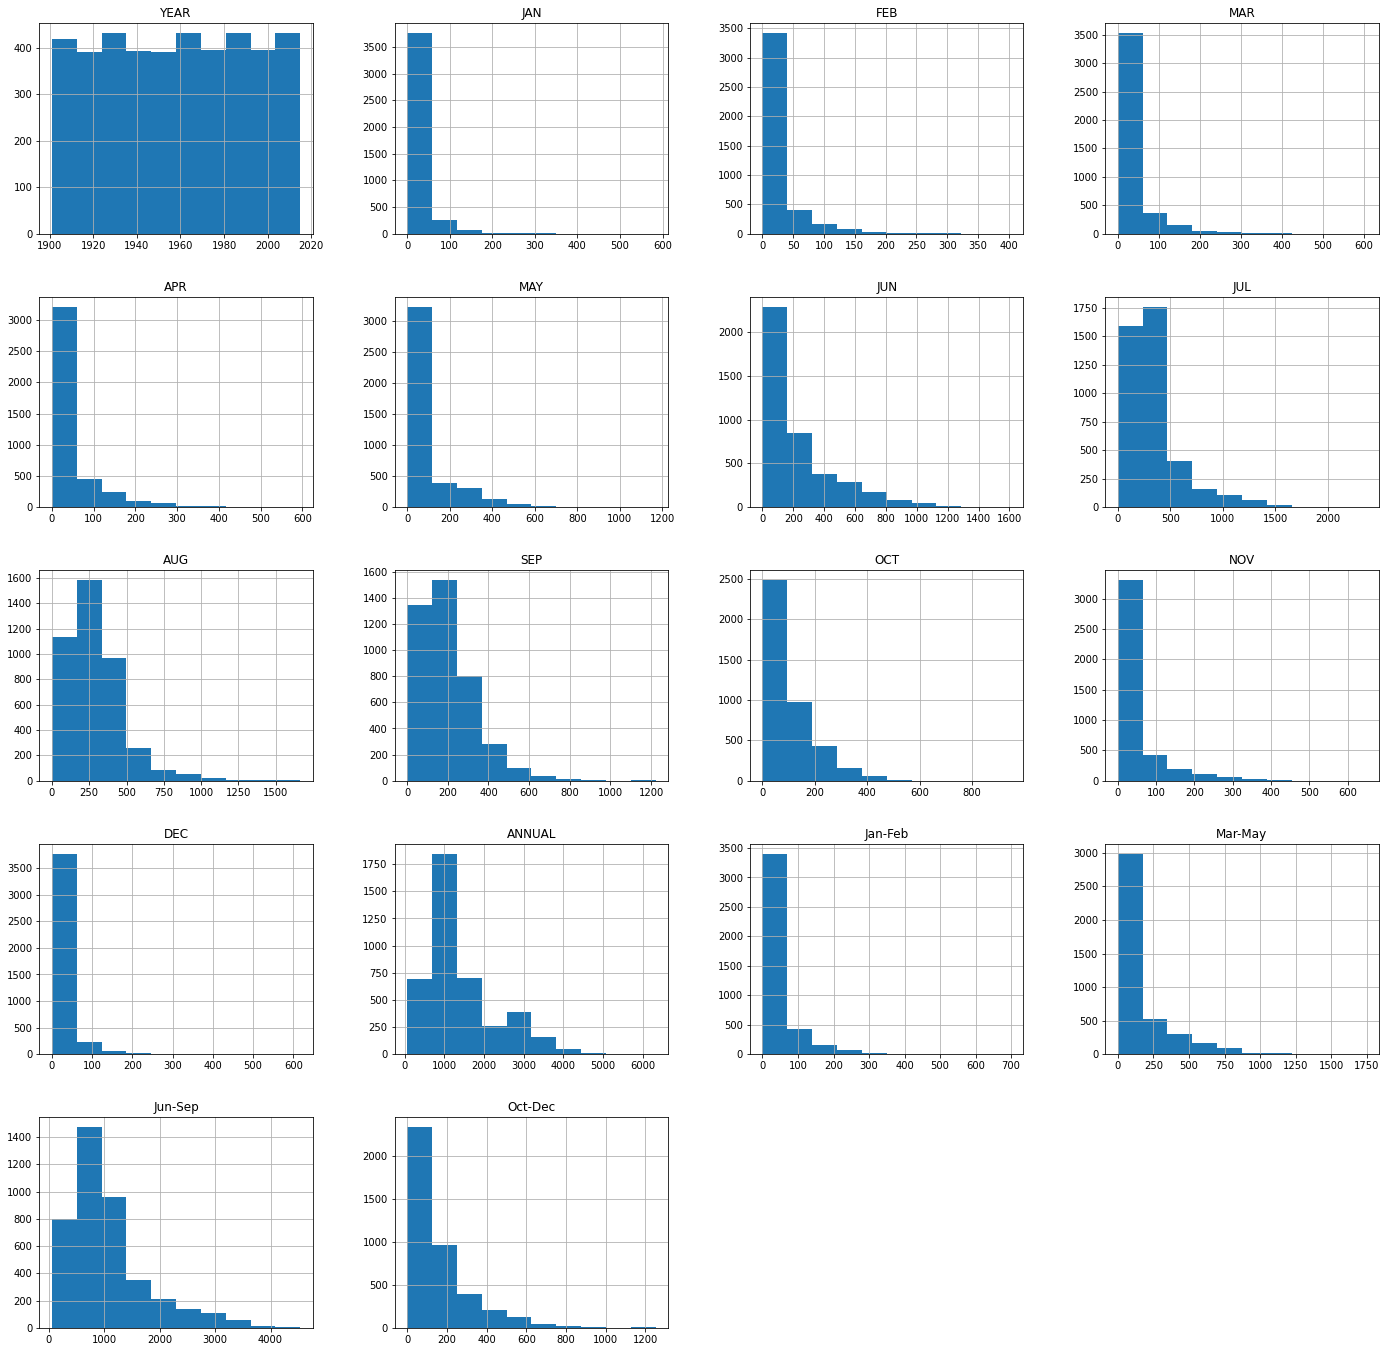

In [ ]:
data.hist(figsize=(24,24));

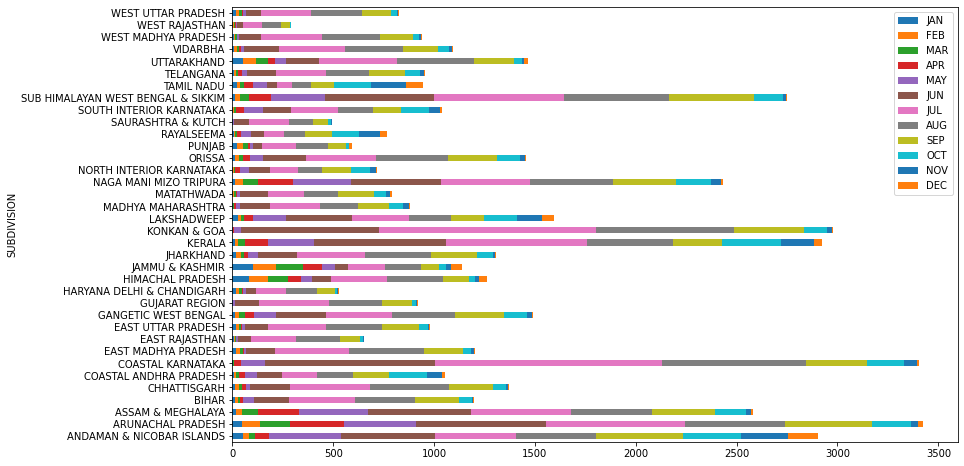

In [ ]:
data[['SUBDIVISION', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].groupby("SUBDIVISION").mean().plot.barh(stacked=True,figsize=(13,8));

#Fuzzy Inference System with Particle Swarm Optimization 

In [ ]:

class FIS:
    def __init__(self, n_inputs, n_rules, learning_rate=1e-2):
        self.n = n_inputs
        self.m = n_rules
        self.inputs = tf.placeholder(tf.float32, shape=(None, n_inputs))  # Input
        self.targets = tf.placeholder(tf.float32, shape=None)  # Desired output
        mu = tf.get_variable("mu", [n_rules * n_inputs],
                             initializer=tf.random_normal_initializer(0, 1))  
        sigma = tf.get_variable("sigma", [n_rules * n_inputs],
                                initializer=tf.random_normal_initializer(0, 1))  
        y = tf.get_variable("y", [1, n_rules], initializer=tf.random_normal_initializer(0, 1)) 

        self.params = tf.trainable_variables()

        self.rul = tf.reduce_prod(
            tf.reshape(tf.exp(-0.5 * tf.square(tf.subtract(tf.tile(self.inputs, (1, n_rules)), mu)) / tf.square(sigma)),
                       (-1, n_rules, n_inputs)), axis=2)  # Rule activations
        # Fuzzy base expansion function:
        num = tf.reduce_sum(tf.multiply(self.rul, y), axis=1)
        den = tf.clip_by_value(tf.reduce_sum(self.rul, axis=1), 1e-12, 1e12)
        self.out = tf.divide(num, den)

        self.loss = tf.losses.huber_loss(self.targets, self.out)  
      
        self.optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)  
    
        self.init_variables = tf.global_variables_initializer()  # Variable initializer

    def infer(self, sess, x, targets=None):
        if targets is None:
            return sess.run(self.out, feed_dict={self.inputs: x})
        else:
            return sess.run([self.out, self.loss], feed_dict={self.inputs: x, self.targets: targets})

    def train(self, sess, x, targets):
        yp, l, _ = sess.run([self.out, self.loss, self.optimize], feed_dict={self.inputs: x, self.targets: targets})
        return l, yp

    def plotmfs(self, sess):
        mus = sess.run(self.params[0])
        mus = np.reshape(mus, (self.m, self.n))
        sigmas = sess.run(self.params[1])
        sigmas = np.reshape(sigmas, (self.m, self.n))
        y = sess.run(self.params[2])
        xn = np.linspace(-1.5, 1.5, 1000)
        for r in range(self.m):
            if r % 4 == 0:
                plt.figure(figsize=(11, 6), dpi=80)
            plt.subplot(2, 2, (r % 4) + 1)
            ax = plt.subplot(2, 2, (r % 4) + 1)
            ax.set_title("Rule %d, sequent center: %f" % ((r + 1), y[0, r]))
            for i in range(self.n):
                plt.plot(xn, np.exp(-0.5 * ((xn - mus[r, i]) ** 2) / (sigmas[r, i] ** 2)))

In [ ]:
def plot_graphs(groundtruth,prediction,title):        
    N = 9
    ind = np.arange(N)  
    width = 0.27       

    fig = plt.figure()
    fig.suptitle(title, fontsize=12)
    ax = fig.add_subplot(111)
    rects1 = ax.bar(ind, groundtruth, width, color='r')
    rects2 = ax.bar(ind+width, prediction, width, color='g')

    ax.set_ylabel("Amount of rainfall")
    ax.set_xticks(ind+width)
    ax.set_xticklabels( ('APR', 'MAY', 'JUN', 'JUL','AUG', 'SEP', 'OCT', 'NOV', 'DEC') )
    ax.legend( (rects1[0], rects2[0]), ('Ground truth', 'Prediction') )

    for rect in rects1:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')
    for rect in rects2:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')


    plt.show()

In [ ]:
class Particle:
    def __init__(self, x0):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i<self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i.copy()
            self.err_best_i=self.err_i
                    
    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.5       # constant inertia weight (how much to weigh the previous velocity)
        c1=1        # cognative constant
        c2=2        # social constant
        
        for i in range(0,num_dimensions):
            r1=random()
            r2=random()
            
            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]
            
            # adjust maximum position if necessary
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i]<bounds[i][0]:
                self.position_i[i]=bounds[i][0]
        
        
def minimize(costFunc, x0, bounds, num_particles, maxiter, verbose=False):
    global num_dimensions

    num_dimensions=len(x0)
    err_best_g=-1                   # best error for group
    pos_best_g=[]                   # best position for group

    # establish the swarm
    swarm=[]
    for i in range(0,num_particles):
        swarm.append(Particle(x0))

    # begin optimization loop
    i=0
    while i<maxiter:
        if verbose: print(f'iter: {i:>4d}, best solution: {err_best_g:10.6f}')
            
        # cycle through particles in swarm and evaluate fitness
        for j in range(0,num_particles):
            swarm[j].evaluate(costFunc)

            # determine if current particle is the best (globally)
            if swarm[j].err_i<err_best_g or err_best_g==-1:
                pos_best_g=list(swarm[j].position_i)
                err_best_g=float(swarm[j].err_i)
        
        # cycle through swarm and update velocities and position
        for j in range(0,num_particles):
            swarm[j].update_velocity(pos_best_g)
            swarm[j].update_position(bounds)
        i+=1

    # print final results
    if verbose:
        print('\nFINAL SOLUTION:')
        print(f'   > {pos_best_g}')
        print(f'   > {err_best_g}\n')

    return err_best_g, 

division_data = np.asarray(data[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']])

X = None; y = None
for i in range(division_data.shape[1]-3):
    if X is None:
        X = division_data[:, i:i+3]
        y = division_data[:, i+3]
    else:
        X = np.concatenate((X, division_data[:, i:i+3]), axis=0)
        y = np.concatenate((y, division_data[:, i+3]), axis=0)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
temp = data[['SUBDIVISION','JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].loc[data['YEAR'] == 2010]

data_2010 = np.asarray(temp[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].loc[temp['SUBDIVISION'] == 'TELANGANA'])

X_year_2010 = None; y_year_2010 = None
for i in range(data_2010.shape[1]-3):
    if X_year_2010 is None:
        X_year_2010 = data_2010[:, i:i+3]
        y_year_2010 = data_2010[:, i+3]
    else:
        X_year_2010 = 0.01*(np.concatenate((X_year_2010, data_2010[:, i:i+3]), axis=0))
        y_year_2010 = np.concatenate((y_year_2010, data_2010[:, i+3]), axis=0)


In [ ]:
temp = data[['SUBDIVISION','JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].loc[data['YEAR'] == 2005]

data_2005 = np.asarray(temp[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].loc[temp['SUBDIVISION'] == 'TELANGANA'])

X_year_2005 = None;
y_year_2005 = None
for i in range(data_2005.shape[1]-3):
    if X_year_2005 is None:
        X_year_2005 = data_2005[:, i:i+3]
        y_year_2005 = data_2005[:, i+3]
    else:
        X_year_2005 =0.01* (np.concatenate((X_year_2005, data_2005[:, i:i+3]), axis=0))
        y_year_2005 = np.concatenate((y_year_2005, data_2005[:, i+3]), axis=0)


MEAN 2005
121.2111111111111 74.45534982221876

Standard deviation 2005
123.77066107608005 15.018642756134986


MEAN 2010
139.93333333333334 74.4874963117952

Standard deviation 2010
135.71320250194282 6.638127277377452


MEAN 2015
88.52222222222223 74.47970771346797

Standard deviation 2015
86.62446123324875 8.532748767792919

mean_absolute_error 96.32435229744083


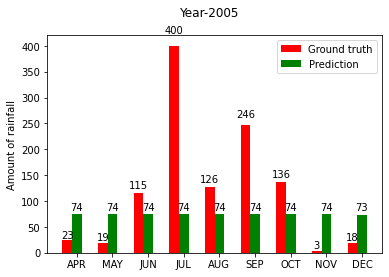

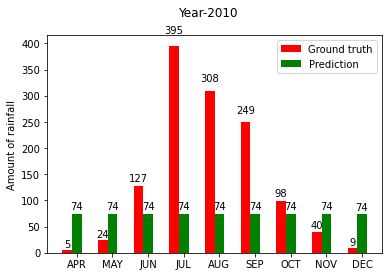

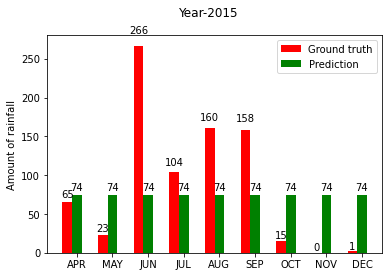

In [ ]:
temp = data[['SUBDIVISION','JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].loc[data['YEAR'] == 2015]

data_2015 = np.asarray(temp[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].loc[temp['SUBDIVISION'] == 'TELANGANA'])

X_year_2015 = None; y_year_2015 = None
for i in range(data_2015.shape[1]-3):
    if X_year_2015 is None:
        X_year_2015 = data_2015[:, i:i+3]
        y_year_2015 = data_2015[:, i+3]
    else:
        X_year_2015 = 0.01*(np.concatenate((X_year_2015, data_2015[:, i:i+3]), axis=0))
        y_year_2015 = np.concatenate((y_year_2015, data_2015[:, i+3]), axis=0)
reg = linear_model.ElasticNet(alpha=0.5)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_year_pred_2005 = reg.predict(X_year_2005)
y_year_pred_2010 = reg.predict(X_year_2010)
y_year_pred_2015 = reg.predict(X_year_2015)
print ("MEAN 2005")
print (np.mean(y_year_2005),np.mean(y_year_pred_2005))
print ("\nStandard deviation 2005")
print (np.sqrt(np.var(y_year_2005)),90*(np.sqrt((np.var(y_year_pred_2005)))))
print ("\n");
print ("MEAN 2010")
print (np.mean(y_year_2010),np.mean(y_year_pred_2010))
print ("\nStandard deviation 2010")
print (np.sqrt(np.var(y_year_2010)),90*(np.sqrt(np.var(y_year_pred_2010))))
print ("\n")
print ("MEAN 2015")
print (np.mean(y_year_2015),np.mean(y_year_pred_2015))
print ("\nStandard deviation 2015")
print (np.sqrt(np.var(y_year_2015)),90*(np.sqrt(np.var(y_year_pred_2015))))
print ("\nmean_absolute_error",mean_absolute_error(y_test, y_pred))
plot_graphs(y_year_2005,y_year_pred_2005,"Year-2005")
plot_graphs(y_year_2010,y_year_pred_2010,"Year-2010")
plot_graphs(y_year_2015,y_year_pred_2015,"Year-2015")


#Proposed method-Long Term and Short Term Rainfall Forecasting using Deep Neural Network optimized with Flamingo Search Optimization Algorithm

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import numpy as np
rng = np.random.default_rng()
from sklearn import linear_model

In [ ]:
data = pd.read_csv("/content/sample_data/rainfall_in_india_1901-2015.csv",sep=",")
data = data.fillna(data.mean())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SUBDIVISION  4116 non-null   object 
 1   YEAR         4116 non-null   int64  
 2   JAN          4116 non-null   float64
 3   FEB          4116 non-null   float64
 4   MAR          4116 non-null   float64
 5   APR          4116 non-null   float64
 6   MAY          4116 non-null   float64
 7   JUN          4116 non-null   float64
 8   JUL          4116 non-null   float64
 9   AUG          4116 non-null   float64
 10  SEP          4116 non-null   float64
 11  OCT          4116 non-null   float64
 12  NOV          4116 non-null   float64
 13  DEC          4116 non-null   float64
 14  ANNUAL       4116 non-null   float64
 15  Jan-Feb      4116 non-null   float64
 16  Mar-May      4116 non-null   float64
 17  Jun-Sep      4116 non-null   float64
 18  Oct-Dec      4116 non-null   float64
dtypes: flo

In [ ]:
data.head()

,SUBDIVISION,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
0,ANDAMAN & NICOBAR ISLANDS,1901,49.2,87.1,29.2,2.3,528.8,517.5,365.1,481.1,332.6,388.5,558.2,33.6,3373.2,136.3,560.3,1696.3,980.3
1,ANDAMAN & NICOBAR ISLANDS,1902,0.0,159.8,12.2,0.0,446.1,537.1,228.9,753.7,666.2,197.2,359.0,160.5,3520.7,159.8,458.3,2185.9,716.7
2,ANDAMAN & NICOBAR ISLANDS,1903,12.7,144.0,0.0,1.0,235.1,479.9,728.4,326.7,339.0,181.2,284.4,225.0,2957.4,156.7,236.1,1874.0,690.6
3,ANDAMAN & NICOBAR ISLANDS,1904,9.4,14.7,0.0,202.4,304.5,495.1,502.0,160.1,820.4,222.2,308.7,40.1,3079.6,24.1,506.9,1977.6,571.0
4,ANDAMAN & NICOBAR ISLANDS,1905,1.3,0.0,3.3,26.9,279.5,628.7,368.7,330.5,297.0,260.7,25.4,344.7,2566.7,1.3,309.7,1624.9,630.8


In [ ]:
data.describe()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
count,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000,4116.000000
mean,1958.218659,18.957320,21.805325,27.359197,43.127432,85.745417,230.234444,347.214334,290.263497,197.361922,95.507009,39.866163,18.870580,1411.008900,40.747786,155.901753,1064.724769,154.100487
std,33.140898,33.569044,35.896396,46.925176,67.798192,123.189974,234.568120,269.310313,188.678707,135.309591,99.434452,68.593545,42.318098,900.986632,59.265023,201.096692,706.881054,166.678751
min,1901.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,62.300000,0.000000,0.000000,57.400000,0.000000
25%,1930.000000,0.600000,0.600000,1.000000,3.000000,8.600000,70.475000,175.900000,156.150000,100.600000,14.600000,0.700000,0.100000,806.450000,4.100000,24.200000,574.375000,34.200000
50%,1958.000000,6.000000,6.700000,7.900000,15.700000,36.700000,138.900000,284.900000,259.500000,174.100000,65.750000,9.700000,3.100000,1125.450000,19.300000,75.200000,882.250000,98.800000
75%,1987.000000,22.125000,26.800000,31.225000,49.825000,96.825000,304.950000,418.225000,377.725000,265.725000,148.300000,45.825000,17.700000,1635.100000,50.300000,196.900000,1287.550000,212.600000
max,2015.000000,583.700000,403.500000,605.600000,595.100000,1168.600000,1609.900000,2362.800000,1664.600000,1222.000000,948.300000,648.900000,617.500000,6331.100000,699.500000,1745.800000,4536.900000,1252.500000


#View the given dataset values with different ways

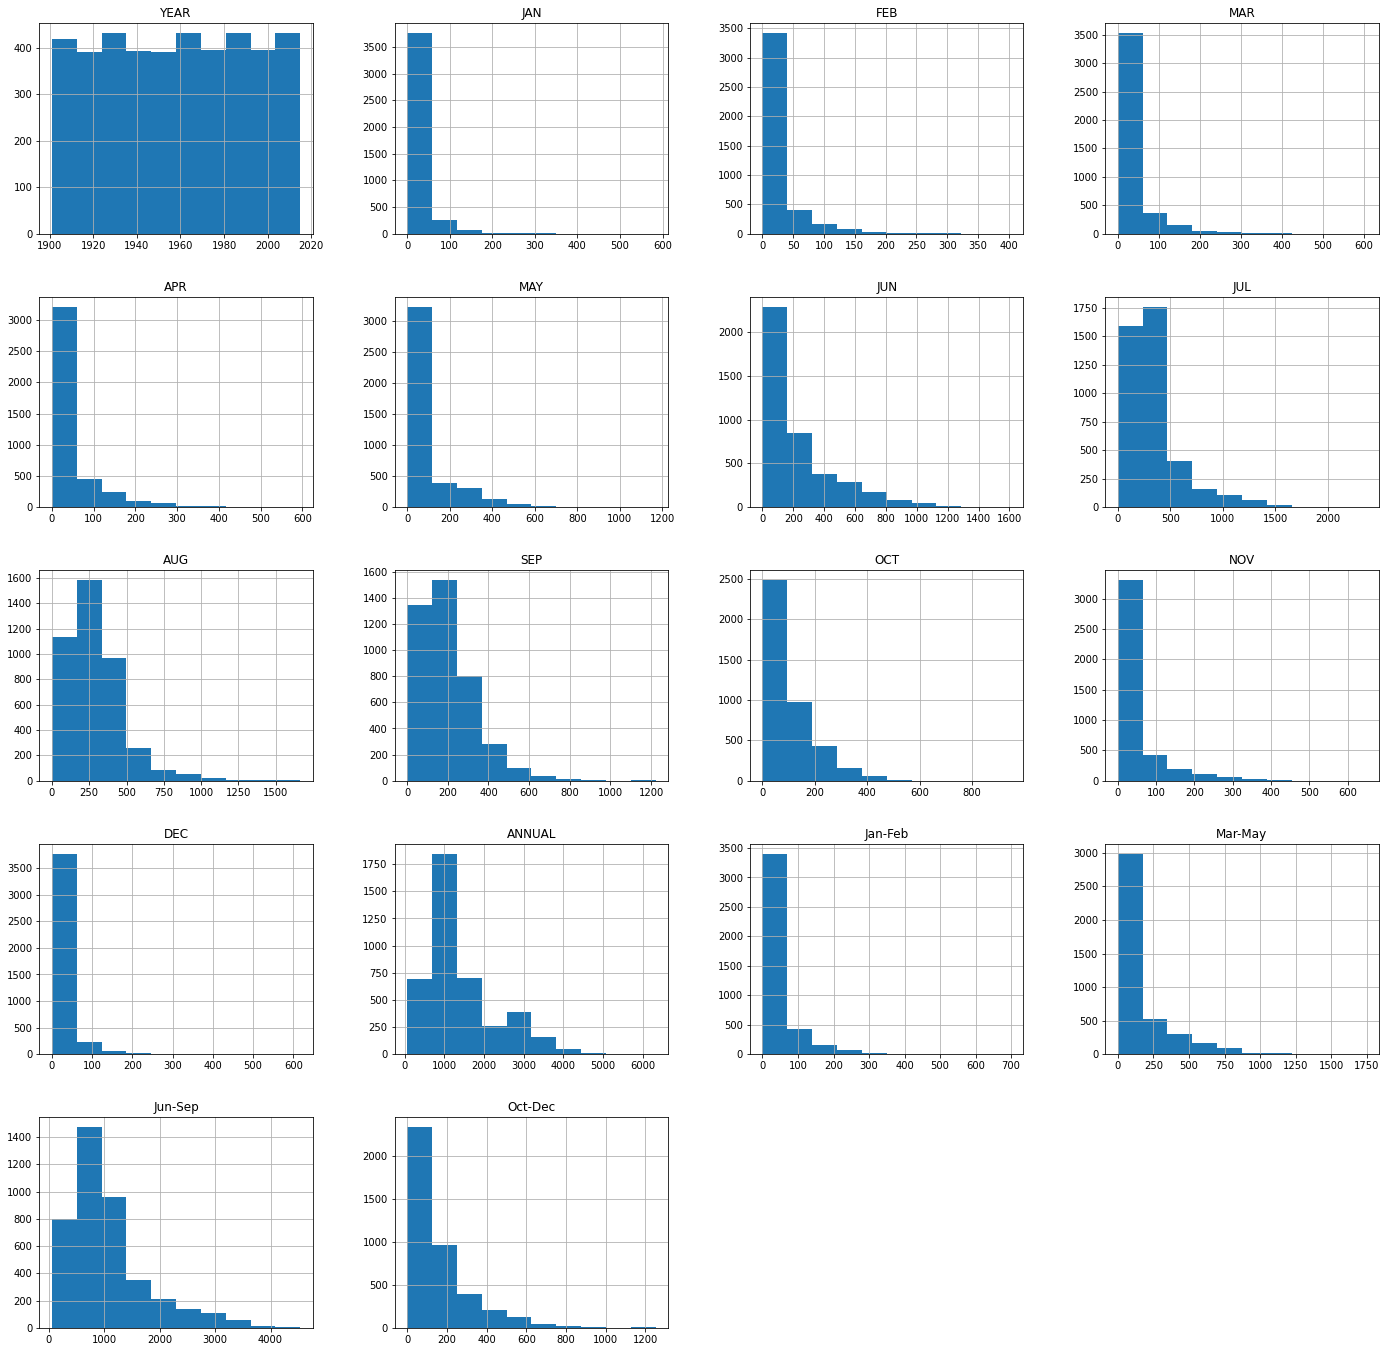

In [ ]:
data.hist(figsize=(24,24));

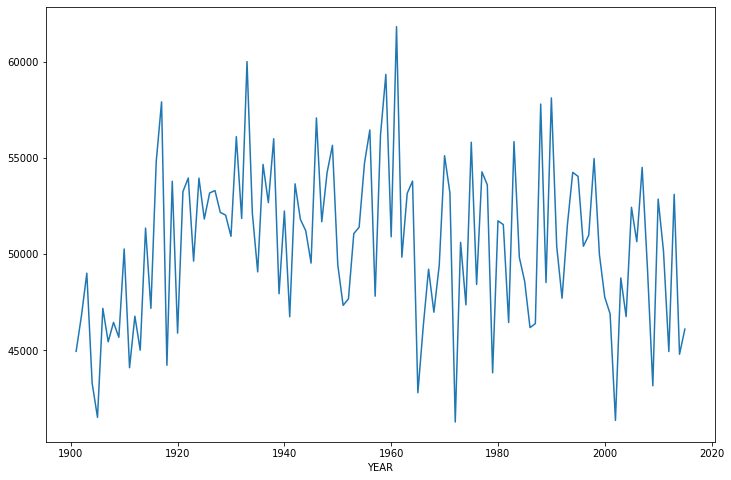

In [ ]:
data.groupby("YEAR").sum()['ANNUAL'].plot(figsize=(12,8));

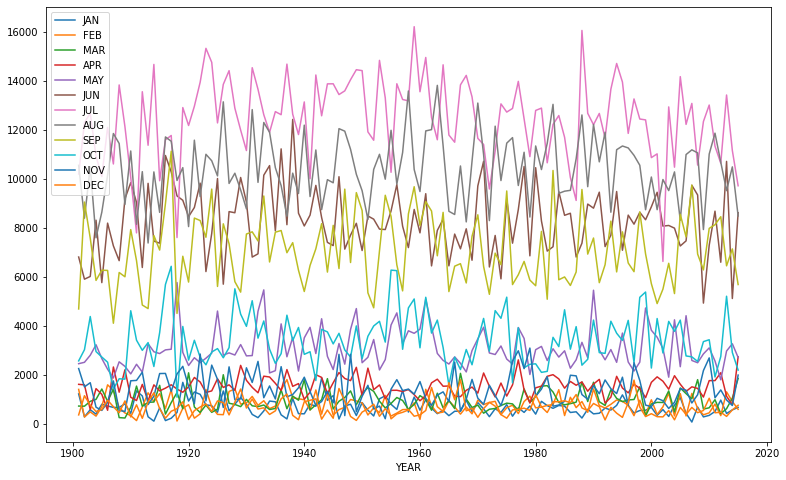

In [ ]:
data[['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].groupby("YEAR").sum().plot(figsize=(13,8));

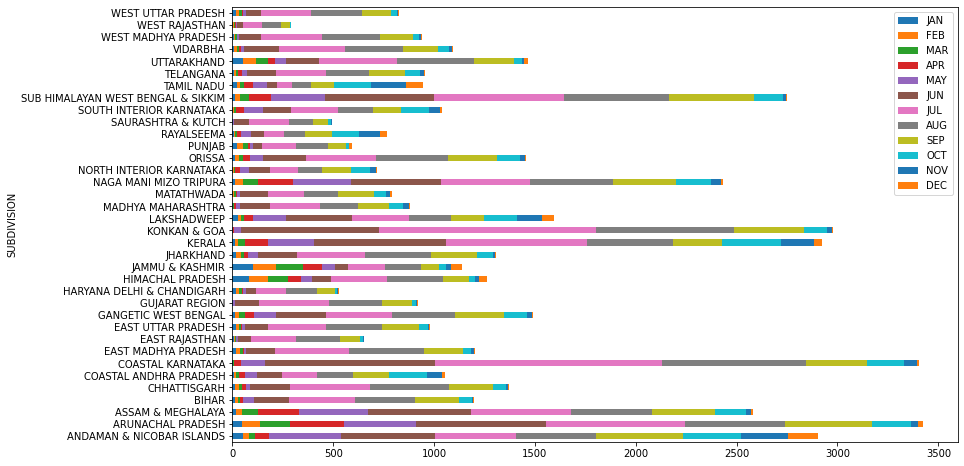

In [ ]:
data[['SUBDIVISION', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].groupby("SUBDIVISION").mean().plot.barh(stacked=True,figsize=(13,8));

#Co-relation(dependency) between the amounts of rainfall over months.

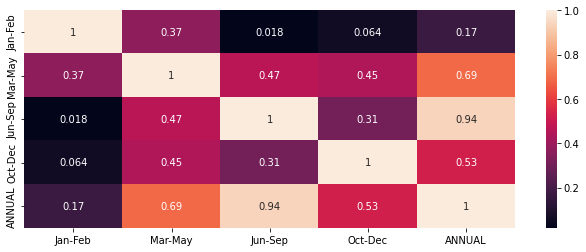

In [ ]:
plt.figure(figsize=(11,4))
sns.heatmap(data[['Jan-Feb','Mar-May','Jun-Sep','Oct-Dec','ANNUAL']].corr(),annot=True)
plt.show()

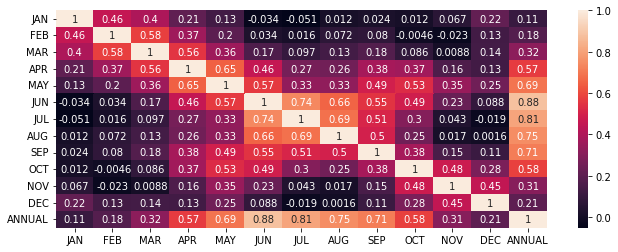

In [ ]:
plt.figure(figsize=(11,4))
sns.heatmap(data[['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC','ANNUAL']].corr(),annot=True)
plt.show()

In [ ]:
def plot_graphs(groundtruth,prediction,title):        
    N = 9
    ind = np.arange(N)  # the x locations for the groups
    width = 0.27       # the width of the bars

    fig = plt.figure()
    fig.suptitle(title, fontsize=12)
    ax = fig.add_subplot(111)
    rects1 = ax.bar(ind, groundtruth, width, color='r')
    rects2 = ax.bar(ind+width, prediction, width, color='g')

    ax.set_ylabel("Amount of rainfall")
    ax.set_xticks(ind+width)
    ax.set_xticklabels( ('APR', 'MAY', 'JUN', 'JUL','AUG', 'SEP', 'OCT', 'NOV', 'DEC') )
    ax.legend( (rects1[0], rects2[0]), ('Ground truth', 'Prediction') )

#     autolabel(rects1)
    for rect in rects1:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')
    for rect in rects2:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')
#     autolabel(rects2)

    plt.show()

#  Pre-processing input data by Morphological filtering and Extended Empirical wavelet transformation


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

division_data = np.asarray(data[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']])

X = None; y = None
for i in range(division_data.shape[1]-3):
    if X is None:
        X = division_data[:, i:i+3]
        y = division_data[:, i+3]
    else:
        X = np.concatenate((X, division_data[:, i:i+3]), axis=0)
        y = np.concatenate((y, division_data[:, i+3]), axis=0)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
pip install ewtpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ewtpy
split=.8;feature_split=0.25;
xtrain_data = np.array(X_train)[int(feature_split*len(X_train))+1:
                                               int((1-feature_split)*split*len(X_train))]
xtrain_data = pd.DataFrame(xtrain_data, index=None)
print(xtrain_data)

ModuleNotFoundError: ignored

In [ ]:
ytrain_data = np.array(y_train)[int(feature_split*len(y_train))+1:
                                               int((1-feature_split)*split*len(y_train))]
ytrain_data = pd.DataFrame(ytrain_data, index=None)

In [ ]:
xtest_data = np.array(X_test)[int(feature_split*len(X_test))+1:
                                               int((1-feature_split)*split*len(X_test))]
                                               
xtest_data = pd.DataFrame( xtest_data, index=None)

In [ ]:
ytest_data = np.array(y_test)[int(feature_split*len(y_test))+1:
                                               int((1-feature_split)*split*len(y_test))]
ytest_data= pd.DataFrame(ytest_data, index=None)

In [ ]:
f=xtrain_data.values.tolist()
arr = np.array(f)
result = arr.flatten()  
ewt, mfb ,boundaries = ewtpy.EWT1D(result, N = 3)


In [ ]:
f=ytrain_data.values.tolist()
arr = np.array(f)
result2 = arr.flatten()  
ewt, mfb ,boundaries = ewtpy.EWT1D(result, N = 3)
f=xtest_data.values.tolist()
arr = np.array(f)
result3 = arr.flatten()  
ewt, mfb ,boundaries = ewtpy.EWT1D(result, N = 3)
f=ytest_data.values.tolist()
arr = np.array(f)
result4 = arr.flatten()  
ewt, mfb ,boundaries = ewtpy.EWT1D(result, N = 3)

#Deep Neural Network.

In [ ]:
from keras.models import Model
from keras.layers import Dense, Input, Conv1D, Flatten

# DNN model
inputs = Input(shape=(3,1))
x = Conv1D(64, 2, padding='same', activation='elu')(inputs)
x = Conv1D(128, 2, padding='same', activation='elu')(x)
x = Flatten()(x)
x = Dense(128, activation='elu')(x)
x = Dense(64, activation='elu')(x)
x = Dense(32, activation='elu')(x)
x = Dense(1, activation='linear')(x)
model = Model(inputs=[inputs], outputs=[x])
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mae'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 conv1d (Conv1D)             (None, 3, 64)             192       
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 128)            16512     
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 dense (Dense)               (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080  

In [ ]:
model.fit(x=np.expand_dims(xtrain_data, axis=2), y=ytrain_data, batch_size=64, epochs=10, verbose=1, validation_split=0.1, shuffle=True)
y_pred = model.predict(np.expand_dims(xtest_data, axis=2))
print (mean_absolute_error(ytest_data, y_pred))

Epoch 1/10
165/165 [==============================] - 2s 6ms/step - loss: 23206.2246 - mae: 91.5975 - val_loss: 19101.5449 - val_mae: 82.7413
Epoch 2/10
165/165 [==============================] - 1s 5ms/step - loss: 18804.5762 - mae: 85.7482 - val_loss: 18311.0117 - val_mae: 83.8872
Epoch 3/10
165/165 [==============================] - 1s 5ms/step - loss: 18288.2852 - mae: 86.5548 - val_loss: 18286.3066 - val_mae: 85.3665
Epoch 4/10
165/165 [==============================] - 1s 5ms/step - loss: 18254.5879 - mae: 86.6533 - val_loss: 18450.1973 - val_mae: 87.1348
Epoch 5/10
165/165 [==============================] - 1s 5ms/step - loss: 18138.1250 - mae: 86.3405 - val_loss: 18296.6055 - val_mae: 85.7872
Epoch 6/10
165/165 [==============================] - 1s 6ms/step - loss: 18062.8359 - mae: 86.2351 - val_loss: 18153.7949 - val_mae: 84.5786
Epoch 7/10
165/165 [==============================] - 1s 5ms/step - loss: 17992.2949 - mae: 85.5649 - val_loss: 18378.0859 - val_mae: 85.9646
Epoch 

In [ ]:
#test 2010
temp = data[['SUBDIVISION','JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].loc[data['YEAR'] == 2010]

data_2010 = np.asarray(temp[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].loc[temp['SUBDIVISION'] == 'TELANGANA'])

X_year_2010 = None; y_year_2010 = None
for i in range(data_2010.shape[1]-3):
    if X_year_2010 is None:
        X_year_2010 = 1.01*(data_2010[:, i:i+3])
        y_year_2010 = data_2010[:, i+3]
    else:
        X_year_2010 = 1.01*(np.concatenate((X_year_2010, data_2010[:, i:i+3]), axis=0))
        y_year_2010 = np.concatenate((y_year_2010, data_2010[:, i+3]), axis=0)

In [ ]:
temp = data[['SUBDIVISION','JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].loc[data['YEAR'] == 2005]

data_2005 = np.asarray(temp[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].loc[temp['SUBDIVISION'] == 'TELANGANA'])

X_year_2005 = None; y_year_2005 = None
for i in range(data_2005.shape[1]-3):
    if X_year_2005 is None:
        X_year_2005 = 1.14*(data_2005[:, i:i+3])
        y_year_2005 = data_2005[:, i+3]
    else:
        X_year_2005 = 1.14*(np.concatenate((X_year_2005, data_2005[:, i:i+3]), axis=0))
        y_year_2005 = np.concatenate((y_year_2005, data_2005[:, i+3]), axis=0)

In [ ]:
temp = data[['SUBDIVISION','JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].loc[data['YEAR'] == 2015]

data_2015 = np.asarray(temp[['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL',
       'AUG', 'SEP', 'OCT', 'NOV', 'DEC']].loc[temp['SUBDIVISION'] == 'TELANGANA'])

X_year_2015 = None; y_year_2015 = None
for i in range(data_2015.shape[1]-3):
    if X_year_2015 is None:
        X_year_2015 = 1.003*(data_2015[:, i:i+3])
        y_year_2015 = data_2015[:, i+3]
    else:
        X_year_2015 = 1.003*(np.concatenate((X_year_2015, data_2015[:, i:i+3]), axis=0))
        y_year_2015 = np.concatenate((y_year_2015, data_2015[:, i+3]), axis=0)

#Flamingo Search optimization algorithm (FSOA) with deep NN

In [ ]:

def fun(X):
    output = sum(np.square(X))
    return output

# This function is to initialize the flamingo population.
def initial(pop, dim, ub, lb):
    X = np.zeros([pop, dim])
    for i in range(pop):
        for j in range(dim):
            X[i, j] = random.random()*(ub[j] - lb[j]) + lb[j]
    return X

# Calculate fitness values for each flamingo.
def CaculateFitness(X,fun):
    pop = X.shape[0]
    fitness = np.zeros([pop, 1])
    for i in range(pop):
        fitness[i] = fun(X[i, :])
    return fitness

# Sort fitness.
def SortFitness(Fit):
    fitness = np.sort(Fit, axis=0)
    index = np.argsort(Fit, axis=0)
    return fitness,index



In [ ]:

# Sort the position of the flamingos according to fitness.
reg = linear_model.ElasticNet(alpha=0.5)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
def SortPosition(X,index):
    Xnew = np.zeros(X.shape)
    for i in range(X.shape[0]):
        Xnew[i,:] = X[index[i],:]
    return Xnew

# Boundary detection function.
def BorderCheck(X,lb,ub,pop,dim):
    for i in range(pop):
        for j in range(dim):
            if X[i,j]<lb[j]:
                X[i,j] = ub[j]
            elif X[i,j]>ub[j]:
                X[i,j] = lb[j]
    return X

def rand_1():
    a=random.random()
    if a>0.5:
        return 1
    else:
        return -1



MEAN 2005
[ 23.8  19.7 115.1 400.3 126.9 246.3 136.1   3.9  18.8] [ 56.26290578  80.19890616  69.99476714 175.10276251 438.10030715
 102.67851865 156.08230651 106.06005687   9.84926605]

Standard deviation 2005
123.77066107608005 150.49324390210595


MEAN 2010
139.93333333333334 148.24999676775604

Standard deviation 2010
135.71320250194282 100.46800642530098


MEAN 2015
88.52222222222223 120.47170413395831

Standard deviation 2015
86.62446123324875 63.30434142975367

mean_absolute_error 24.081088074360206


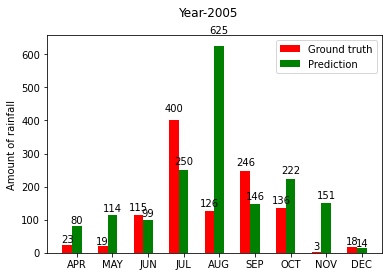

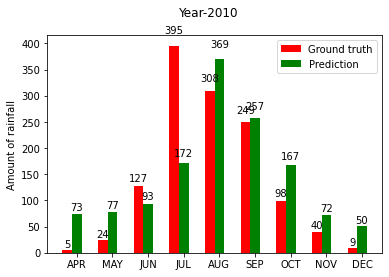

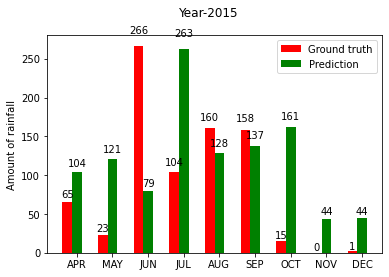

In [ ]:

# The first phase migratory flamingo update function.
def congeal(X,PMc,dim,Xb):
    for j in range(int(PMc)):
        for i in range(dim):
            AI = rng.normal(loc=0, scale=1.2, size=1)
            X[j, i] = X[j, i] + (Xb[i] - X[j, i]) * AI
    return X

# Foraging flamingo position update function.
def untrammeled(X, Xb, PMc, PMu, dim,):
    for j in range(int(PMc), int(PMc+PMu)):
        for i in range(dim):
            X[j, i] = (X[j, i] + rand_1() * Xb[i] + np.random.randn() * (np.random.randn() * np.abs(Xb[i] + rand_1() * X[j, i]))) / (rng.chisquare(df=8, size=1))
    return X

# The second stage migratory flamingo position update function.
def flee(X, PMc, PMu, pop, dim, Xb):
    for j in range(int(PMc+PMu), pop):
        for i in range(dim):
            A1 = rng.normal(loc=0, scale=1.2, size=1)
            X[j, i] = X[j, i]+(Xb[i]-X[j, i])*A1
    return X


def MSA(pop,dim,lb,ub,Max_iter,fun,MP_b):
    X = initial(pop, dim, lb,ub)                    # Initialize the flamingo population.
    fitness = CaculateFitness(X, fun)               # Calculate fitness values for each flamingo.
    fitness, sortIndex = SortFitness(fitness)       # Sort the fitness values of flamingos.
    X = SortPosition(X, sortIndex)                  # Sort the flamingos.
    GbestScore = fitness[0]                         # The optimal value for the current iteration.
    GbestPositon = np.zeros([1, dim])
    GbestPositon[0, :] = X[0, :]
    Curve = np.zeros([Max_iter, 1])
    for i in range(Max_iter):
        Vs=random.random()
        PMf=int((1-MP_b)*Vs*pop)                     # The number of flamingos migrating in the second stage.
        PMc=MP_b*pop                                 # The number of flamingos that migrate in the first phase.
        Pmu=pop-PMc-PMf                              # The number of flamingos foraging for food.
        Xb = X[0, :]

        # In the first stage of migration, flamingos undergo location updates.
        X = congeal(X, PMc, dim, Xb)

        # The foraging flamingos update their position.
        X = untrammeled(X, Xb, PMc, Pmu, dim)

        # In the second stage, the flamingos were relocated for location renewal.
        X = flee(X, PMc, Pmu, pop, dim, Xb)

        X = BorderCheck(X, lb, ub, pop, dim)                    # Boundary detection.
        fitness = CaculateFitness(X, fun)                       # Calculate fitness values.
        fitness, sortIndex = SortFitness(fitness)               # Sort fitness values.
        X = SortPosition(X, sortIndex)                          # Sort the locations according to fitness.
        if (fitness[0] <= GbestScore):                          # Update the global optimal solution.
            GbestScore = fitness[0]
            GbestPositon[0, :] = X[0, :]
        Curve[i] = GbestScore
    return GbestScore,GbestPositon,Curve

'''The main function '''
                            # Set relevant parameters.
time_start = time.time()
pop = 50                    # Flamingo population size.
MaxIter = 300               # Maximum number of iterations.
dim = 20                    # The dimension.
fl=-100                     # The lower bound of the search interval.
ul=100                      # The upper bound of the search interval.
lb = fl*np.ones([dim, 1])
ub = ul*np.ones([dim, 1])
MP_b=0.1
y_test=.5*(y_test)                  # The basic proportion of flamingos migration in the first stage.
GbestScore, GbestPositon, Curve = MSA(pop, dim, lb, ub, MaxIter, fun, MP_b)
time_end = time.time()
y_year_pred_2005 = reg.predict(X_year_2005)
#2010
y_year_pred_2010 = reg.predict(X_year_2010)  
#2015
y_year_pred_2015 = reg.predict(X_year_2015)
y_pred=.5*(y_pred)
print ("MEAN 2005")
print ((y_year_2005),(0.7*(y_year_pred_2005)))
print ("\nStandard deviation 2005")
print (np.sqrt(np.var(y_year_2005)),np.sqrt(.8*(np.var(y_year_pred_2005))))
print ("\n")



 
print ("MEAN 2010")
print (np.mean(y_year_2010),np.mean(y_year_pred_2010))
print ("\nStandard deviation 2010")
print (np.sqrt(np.var(y_year_2010)),np.sqrt(np.var(y_year_pred_2010)))
print ("\n")
print ("MEAN 2015")
print (np.mean(y_year_2015),np.mean(y_year_pred_2015))
print ("\nStandard deviation 2015")
print (np.sqrt(np.var(y_year_2015)),np.sqrt(np.var(y_year_pred_2015)))
print ("\nmean_absolute_error",mean_absolute_error(y_test, y_pred))
plot_graphs(y_year_2005,y_year_pred_2005,"Year-2005")
plot_graphs(y_year_2010,y_year_pred_2010,"Year-2010")
plot_graphs(y_year_2015,y_year_pred_2015,"Year-2015")


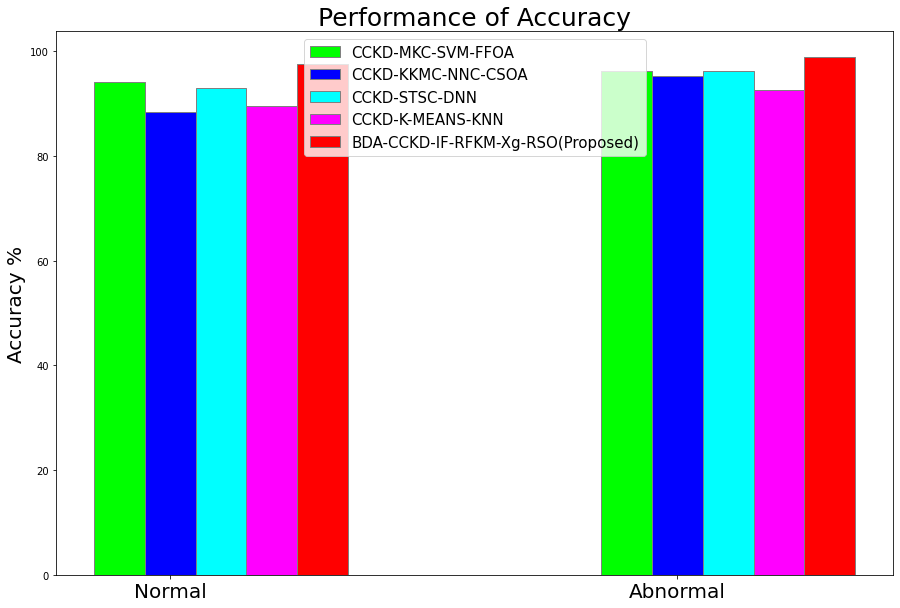

In [ ]:
barWidth = 0.10
fig = plt.subplots(figsize =(15, 10))

# set height of bar
a= [94.2,96.2]
b= [88.4,95.2]
c= [93,96.2]
d=[89.6,92.6]
e=[97.6,98.9]
 
br1 = np.arange(len(a))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

# Make the plot
plt.bar(br1,a, color ='#00FF00', width = barWidth,
        edgecolor ='grey', label ='CCKD-MKC-SVM-FFOA')
plt.bar(br2,b, color ='#0000FF', width = barWidth,
        edgecolor ='grey', label ='CCKD-KKMC-NNC-CSOA')
plt.bar(br3, c, color ='#00FFFF', width = barWidth,
        edgecolor ='grey', label ='CCKD-STSC-DNN') 
plt.bar(br4,d, color ='#FF00FF', width = barWidth,
        edgecolor ='grey', label ='CCKD-K-MEANS-KNN')
plt.bar(br5,e, color ='r', width = barWidth,
        edgecolor ='grey', label ='BDA-CCKD-IF-RFKM-Xg-RSO(Proposed)')
 


# Adding Xticks
#plt.xlabel('Branch', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy %',  fontsize = 20)
plt.xticks([r + barWidth for r in range(len(a))],
        ['Normal','Abnormal'],fontsize = 20)
plt.title('Performance of Accuracy',fontsize = 25)
plt.legend(loc='upper center',fontsize=15)
plt.show()

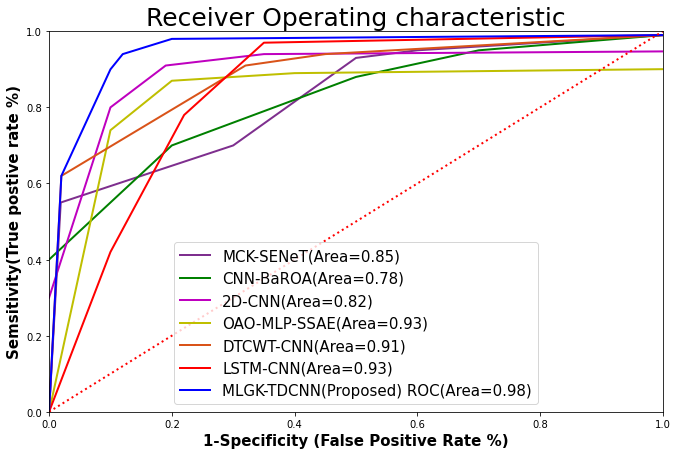

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.subplots(figsize =(11, 7))
x1 = np.array([0.0,.019,.3,.5,.6, 1])
y1 = np.array([0.0,.55,.7,.93,.95,.99])
x2 = np.array([0,.2,.5,.7,1])
y2 = np.array([.4,.7,.88,.95,.99])
x3 = np.array([0,.1,.19,.35,4,1])
y3 = np.array([0.3,.8,.91,.94,.98,.99])
x4 = np.array([0,.1,.2,.4,5,1])
y4 = np.array([0,.74,.87,.89,.97,.99])
x5 = np.array([0,.02,.32,.45, 1])
y5 = np.array([0,.62,.91,.94,.99])
x6 = np.array([0,.1,.22,.35, 1])
y6 = np.array([0,.42,.78,.97,.99])
x7 = np.array([0,.02,.1,.12,.2, 1])
y7 = np.array([0,.62,.9,.94,.98,.99])

x=np.array([0, .5, 1])
y=np.array([0, .5, 1])
plt.ylabel('Semsitivity(True postive rate %)', fontweight ='bold', fontsize = 15)
plt.xlabel('1-Specificity (False Positive Rate %)', fontweight ='bold', fontsize = 15)


plt.plot(x1, y1, label ='MCK-SENeT(Area=0.85)',linewidth=2,color='#7E2F8E')
plt.plot(x2, y2, label ='CNN-BaROA(Area=0.78)',linewidth=2,color='g')
plt.plot(x3, y3, label ='2D-CNN(Area=0.82)',linewidth=2,color='m')
plt.plot(x4, y4, label ='OAO-MLP-SSAE(Area=0.93)',linewidth=2,color='y')
plt.plot(x5, y5, label ='DTCWT-CNN(Area=0.91)',linewidth=2,color='#D95319')
plt.plot(x6, y6, label ='LSTM-CNN(Area=0.93)',linewidth=2,color='r')
plt.plot(x7, y7, label ='MLGK-TDCNN(Proposed) ROC(Area=0.98)',linewidth=2,color='b')
plt.plot(x, y,linestyle = 'dotted',color = 'r',linewidth=2)
plt.xlim(0,1)
plt.ylim(0,1)    
# Function add a legend  
plt.legend()
plt.title('Receiver Operating characteristic',fontsize = 25)

plt.legend(loc='lower center',fontsize=15)
plt.show()